# EPIC Institute of Technology
## Data Science Mid-term Exam

# Data

gender.csv

### Objective features:

Age
Height
Weight
Sex (gender)
Measurement results:

Upper and lower blood pressure (ap_hi, ap_lo)
Cholesterol (cholesterol)
Glucose (glucose)

### Subjective features (according to patients):

Smoking (smoke)
Drinking alcohol (alco)
Physical activity (active)
Target sign (which will be interesting to predict):
The presence of cardiovascular diseases according to the results of a classic medical examination (cardio)

Age is given in days.
The values of cholesterol and glucose are represented by one of three classes: normal, above normal, significantly above normal.
The values of subjective features are binary.

All figures are given at the time of inspection.

## Task 0
### Import necesssary libraries and read the data. Note that data is separated with semicolon ';'

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('gender.csv', delimiter=';')

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Task 1 (2 points) 
### Exploratory Data Analysis (EDA): Create Descriptive Graphs for Initial Data Exploration. 
- Histograms for Age, Height, Weight, ap_hi, and ap_lo to visualize the distribution.
- Bar charts for gender, smoke, alco, and active to show the count of each category.
- Any other graphs that you find useful

In [126]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

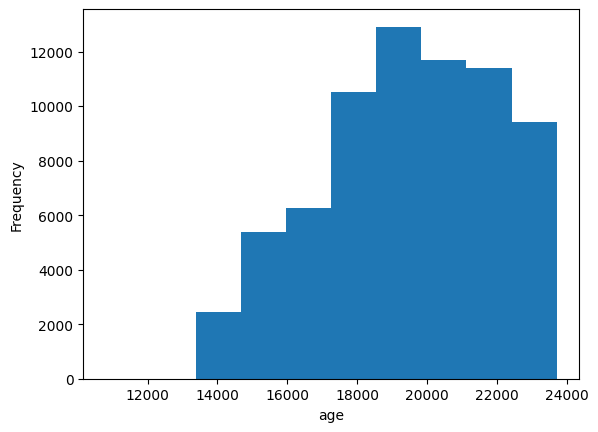

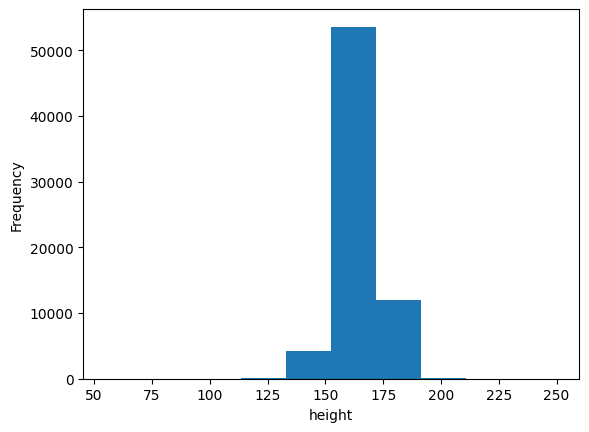

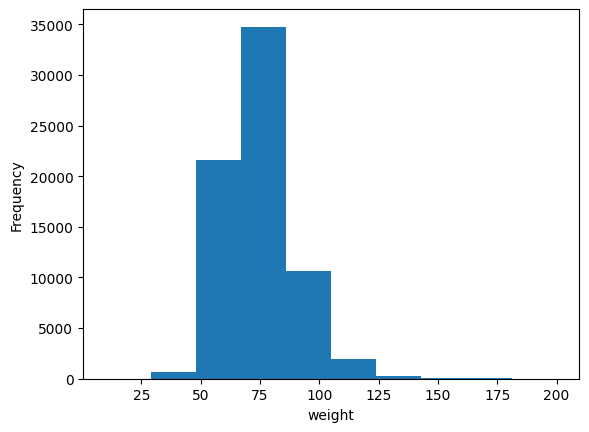

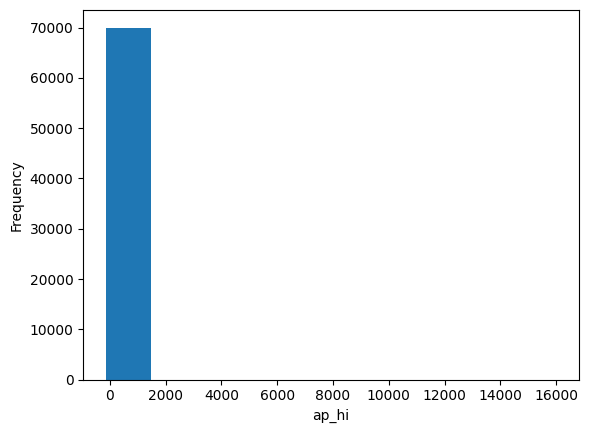

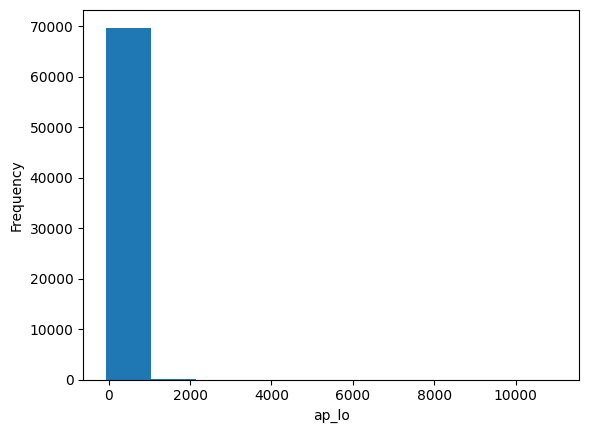

In [127]:
columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

for column in columns:
    df[column].plot(kind='hist', xlabel= column)
    plt.show()

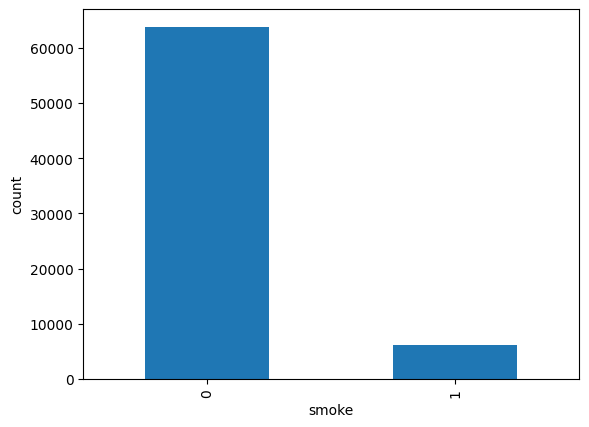

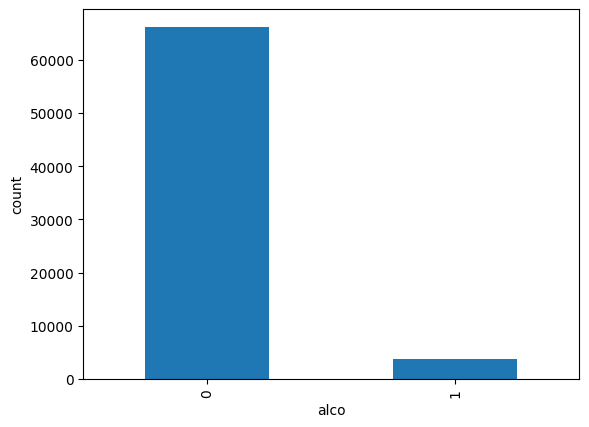

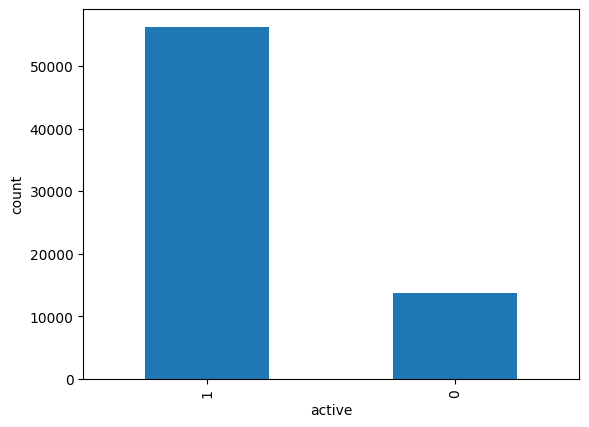

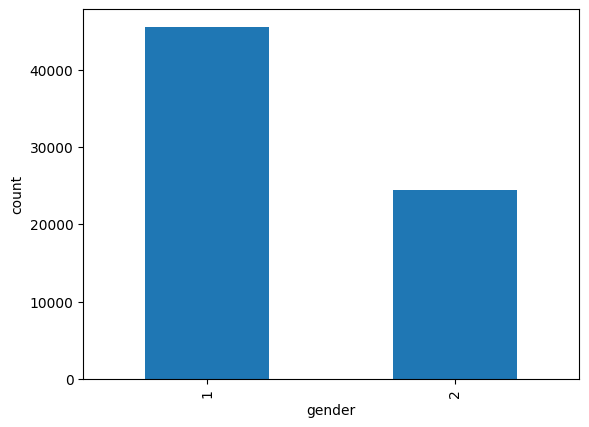

In [128]:
columns = ['smoke', 'alco', 'active', 'gender']

for column in columns:
    df[column].value_counts().plot(kind='bar', ylabel= 'count')
    plt.show()

## Task 2 (1 point) 
### Data Cleaning: Identify and Remove Outliers in Non-Binary Features
- Identify and remove 5% (both bottom and top) of outliers for non-binary features.
- Identify and remove other inappropriate data (such as negative values)

In [129]:
non_binary = []

for index in df.columns:
    if df[[index]].value_counts().size != 2 and index != 'id':
        non_binary.append(index)
        
print(non_binary)

['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']


In [130]:
df = df[df[non_binary].apply(lambda x: (x > 0)).all(axis=1)]

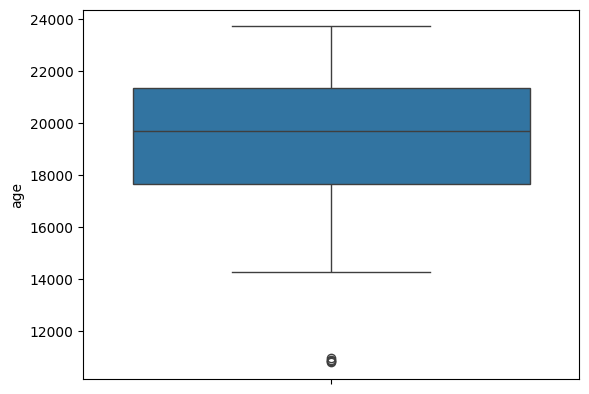

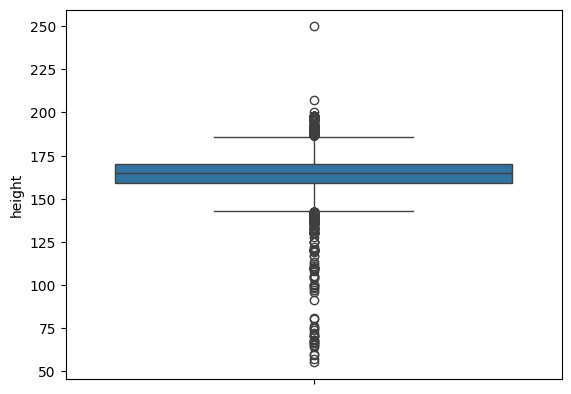

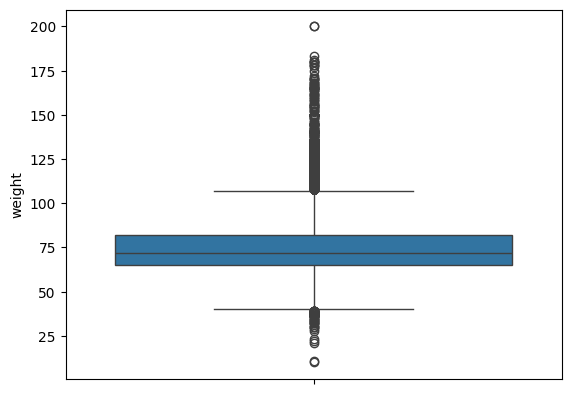

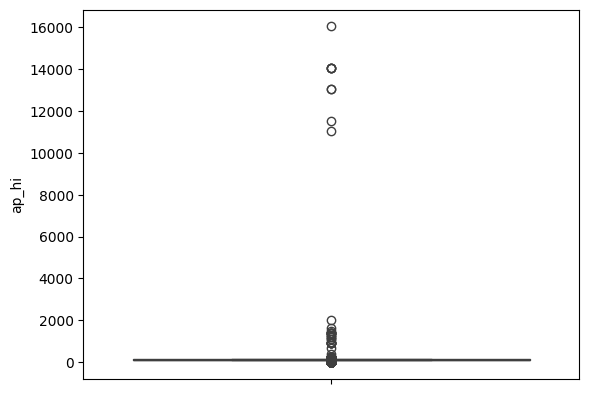

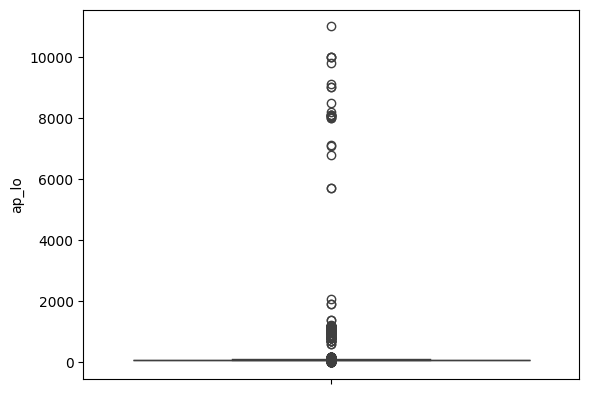

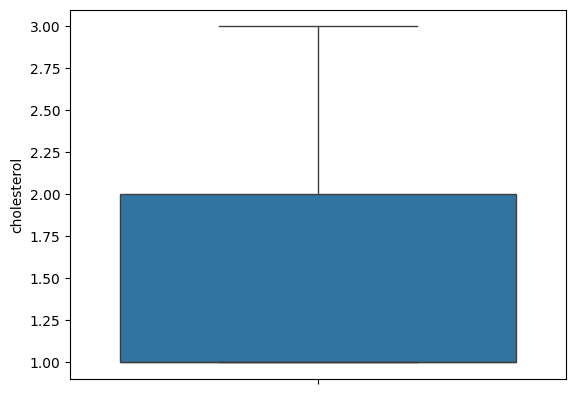

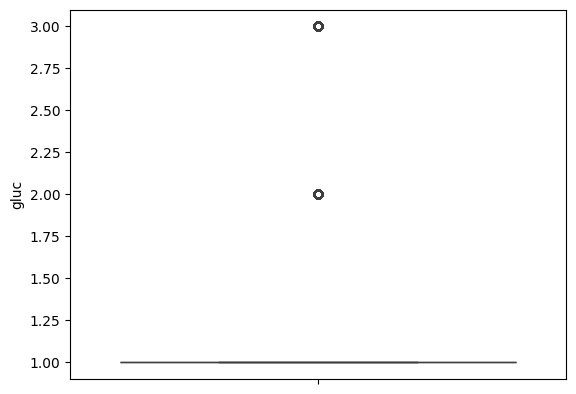

In [131]:
for column in non_binary:
    sns.boxplot(data=df[column])
    plt.show()

In [132]:
def remove_outlier(df, column):
    upper_limit = df[column].quantile(0.95)
    lower_limit = df[column].quantile(0.05)
    print(df.loc[(df[column] > upper_limit) | (df[column] < lower_limit)].shape)
    return df.loc[(df[column] <= upper_limit) & (df[column] >= lower_limit)]

(6996, 13)


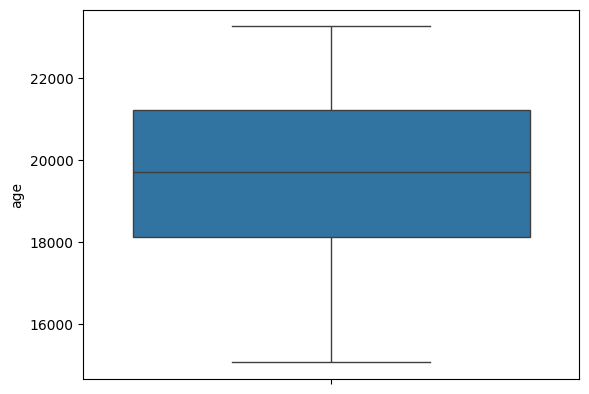

(5297, 13)


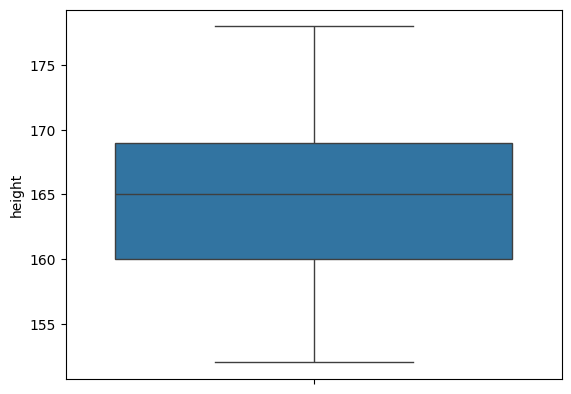

(4781, 13)


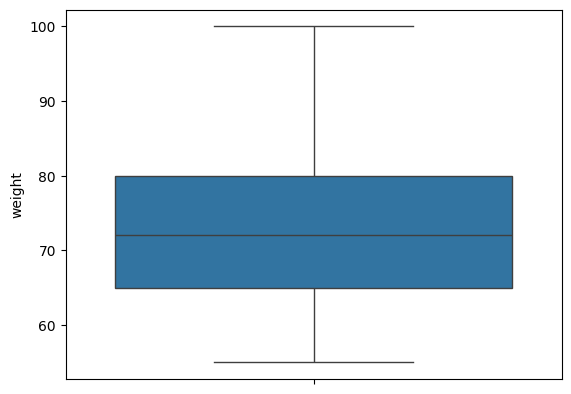

(3877, 13)


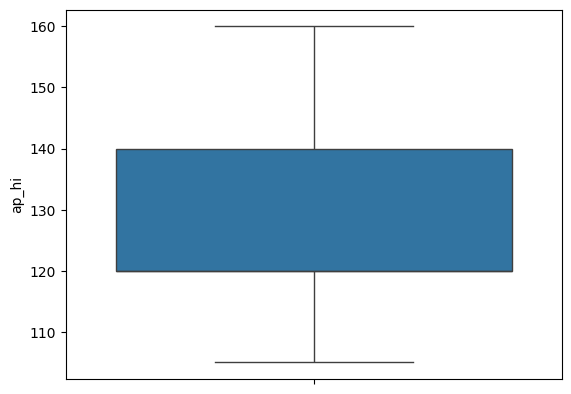

(1727, 13)


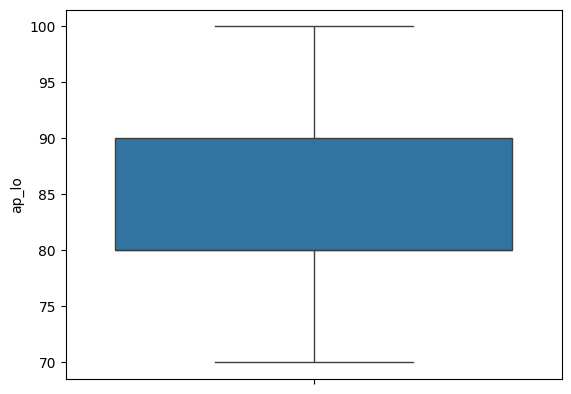

(0, 13)


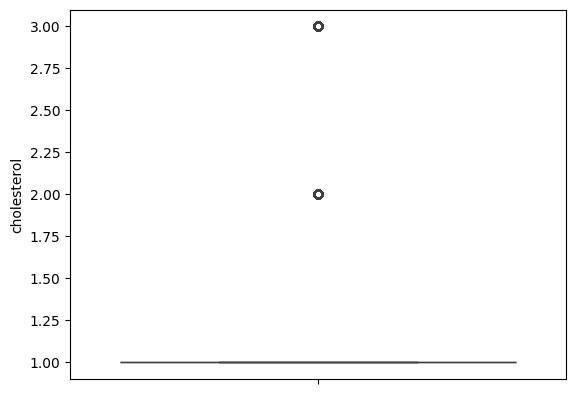

(0, 13)


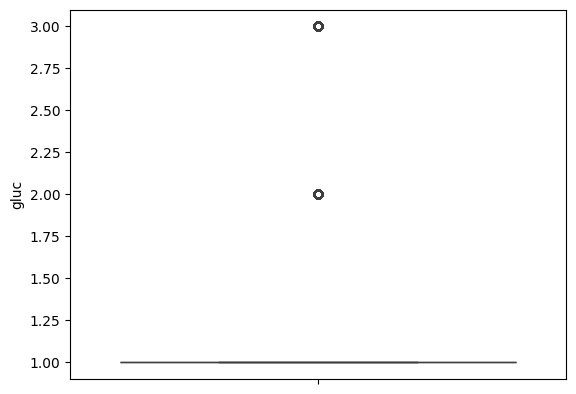

In [133]:
# Remove outliers by trimming
for column in non_binary:
    df = remove_outlier(df, column)
    sns.boxplot(data=df[column])
    plt.show()
    

## Task 3 (1 point)
### Confidence Intervals: Calculate Confidence Intervals for Height and Weight
- After cleaning, calculate the 95% confidence interval for height and 99.7% for weight.

In [134]:
column_data = df['height']
confidence_interval = stats.t.interval(0.95, len(column_data)-1, loc=column_data.mean(), scale=stats.sem(column_data))

confidence_interval

(164.65488502521373, 164.76731276304247)

In [135]:
column_data = df['weight']
confidence_interval = stats.t.interval(0.9907, len(column_data)-1, loc=column_data.mean(), scale=stats.sem(column_data))

confidence_interval

(73.35473789861666, 73.6086968591699)

## Task 4 (1 point)
### Data Transformation - One-Hot Encoding:
- Apply one-hot encoding for cholesterol and glucose.

In [136]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,18393,2,168,62.0,110,80,0,0,1,0,True,False,False,True,False,False
1,1,20228,1,156,85.0,140,90,0,0,1,1,False,False,True,True,False,False
2,2,18857,1,165,64.0,130,70,0,0,0,1,False,False,True,True,False,False
3,3,17623,2,169,82.0,150,100,0,0,1,1,True,False,False,True,False,False
6,9,22113,1,157,93.0,130,80,0,0,1,0,False,False,True,True,False,False


## Task 5 (2 points)
### Hypothesis Testing - T-Test: Investigate Gender Differences in Average Height
- Before conducting the two-tailed t-test to compare the average height between men and women, check for significant differences in variance between the two groups
- If the variance differs significantly, use Welch's t-test

In [137]:
# female average height
female = df[df['gender'] == 1]['height']
female.mean()

162.50737606588206

In [138]:
# male average height
male = df[df['gender'] == 2]['height']
male.mean()

168.84297872340426

In [139]:
statistic, p_value = stats.levene(female, male)

p_value

if p_value < 0.05:
    print("There is a significant difference in variance between the two groups.")
else:
    print("There is no significant difference in variance between the two groups.")

There is a significant difference in variance between the two groups.


In [140]:
t_statistic, p_value = stats.ttest_ind(female, male, equal_var=False)

if p_value < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


## Task 6 (3 points)
### Model building: Build and Optimize Model for Cardiovascular Disease Prediction
- Select a model of your choice and predict Cardiovascular Disease
- Try different hyperparameters to optimize the model
- Calculate model accuracy

In [141]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke',
       'alco', 'active', 'cardio', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'],
      dtype='object')

In [142]:
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3', 'smoke', 'alco', 'active']

X = df[features]
y = df['cardio']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7124431758113966


In [145]:
lm = xgb.XGBClassifier()

lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.711068823342848
